# Import

In [1]:
import torch
import os
from matplotlib import pyplot as plt

from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from utils.image_helpers import load_image, show_images, plot_image_grid, rgb2gray
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.Simulation import Simulation

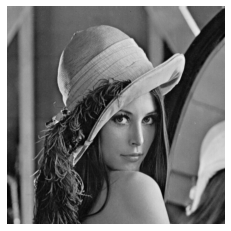

In [2]:
#original_rgb_image = load_image('data/raw_images/sample_images/cameraman.png')
#original_rgb_image = load_image('data/raw_images/sample_images/canonical_mri.png')
original_rgb_image = load_image('data/raw_images/sample_images/lena.png')
original_image = rgb2gray(original_rgb_image)

plt.imshow(original_image, 'gray')
plt.axis('off')
plt.show()

# Gibbs Simulation

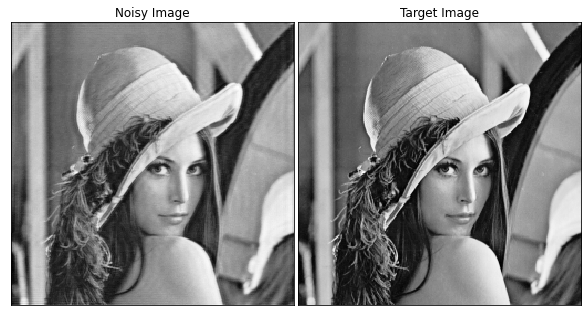

In [3]:
simulation = Simulation(cropped_size=(256,256))
noisy_image, target_image = simulation(original_image)

plot_image_grid([noisy_image, target_image], ['Noisy Image', 'Target Image'], ncols=2)
plt.show()

# Configuration

In [4]:
fit_model_configuration = get_fit_model_configuration()

fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [20, 20]
fit_model_configuration.number_of_hidden_channels = 64
fit_model_configuration.number_of_layers = 4

fit_model_configuration.log_frequency = 10
fit_model_configuration.convergence_check_length = 200

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(str(fit_model_configuration))

number of GPUs:  1
image_dimensions: [256, 256, 1]  
result_path: data/results/  
model_type: deep  
input_shape: [20, 20]  
number_of_layers: 4  
number_of_hidden_channels: 64  
number_of_iterations: 30000  
learning_rate: 0.1  
convergence_check_length: 200  
log_frequency: 10  
find_best: True  
data_type: <class 'torch.cuda.FloatTensor'>  



# Fitting

In [5]:
model = create_model_from_configuration(fit_model_configuration)
fitter = create_fitter_from_configuration(fit_model_configuration)
fitter(model, noisy_image, target_image)

Step: 00800, Loss: 0.000930, Target Loss: 0.062428, Minimum Loss at: 609 with 0.0004080
Adam has converged at step 810.


# Display Results

saved at data/results/2020-11-18-12:47.png


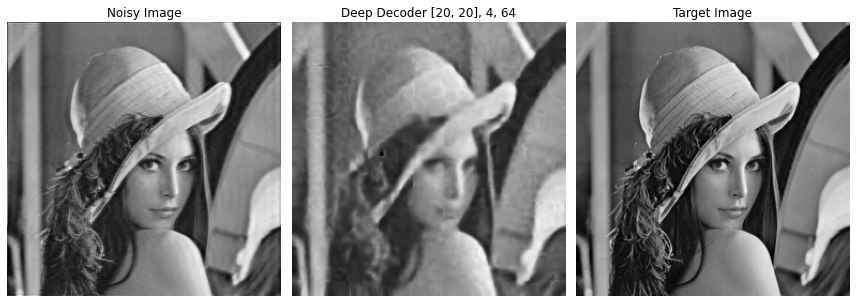

In [6]:
model_image = fitter.get_best_image()
show_images(noisy_image, model_image, target_image, fit_model_configuration.result_path, str(model))

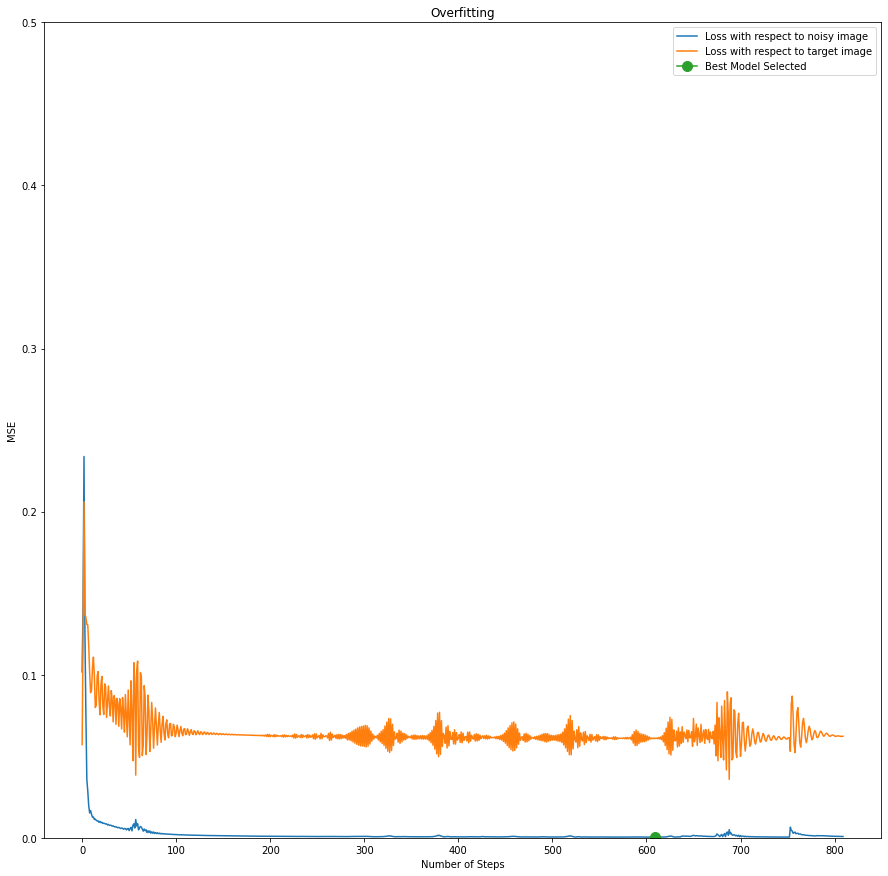

In [7]:
fig = plt.figure(figsize = (15,15))
plt.plot(fitter.losses_wrt_noisy, label = "Loss with respect to noisy image")
plt.plot(fitter.losses_wrt_target, label = "Loss with respect to target image")
plt.plot([fitter.best_model_step], [fitter.best_model_loss.cpu().data], marker='o', ms=10.0, label="Best Model Selected")
plt.xlabel('Number of Steps')
plt.ylabel('MSE')
plt.title('Overfitting')
plt.ylim(0,0.5)
plt.legend()
plt.show()